In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.integrate import quad
from scipy.interpolate import interp1d


In [3]:
data_A = pd.read_csv("/Users/Sophie/desktop/DSC291/group_project/DSC291/Final_Project/datasets/DetectorA.csv")
data_B = pd.read_csv("/Users/Sophie/desktop/DSC291/group_project/DSC291/Final_Project/datasets/DetectorB.csv")
data_C = pd.read_csv("/Users/Sophie/desktop/DSC291/group_project/DSC291/Final_Project/datasets/DetectorC.csv")
data_Target = pd.read_csv("/Users/Sophie/desktop/DSC291/group_project/DSC291/Final_Project/datasets/DetectorTarget.csv")


<Axes: title={'center': 'Detector A Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

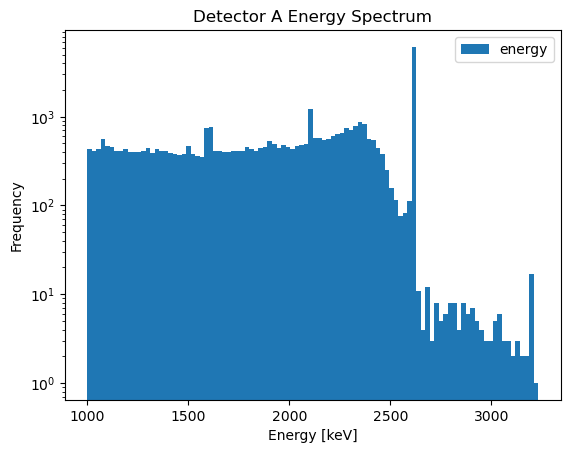

In [4]:
data_A.plot(kind='hist', title='Detector A Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector B Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

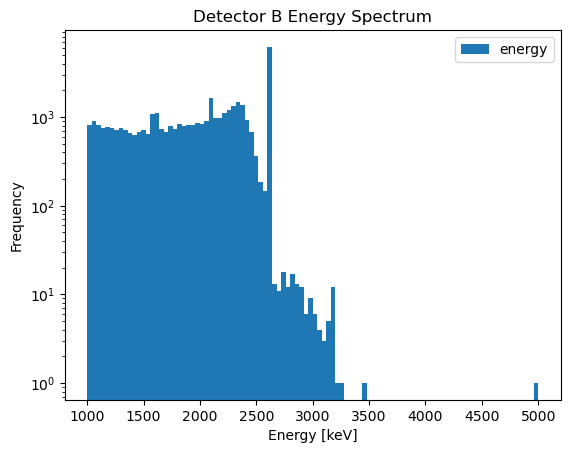

In [5]:
data_B.plot(kind='hist', title='Detector B Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector C Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

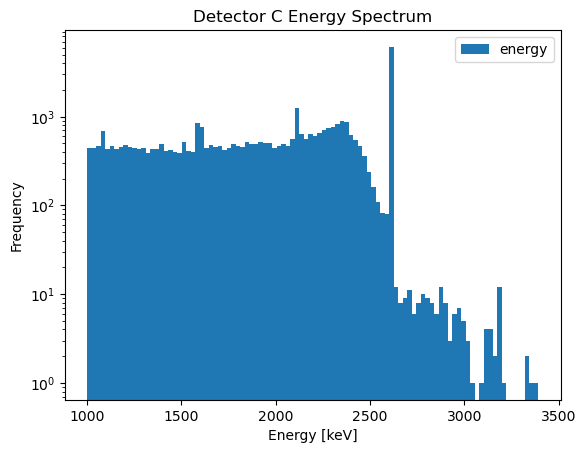

In [6]:
data_C.plot(kind='hist', title='Detector C Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

<Axes: title={'center': 'Detector Target Energy Spectrum'}, xlabel='Energy [keV]', ylabel='Frequency'>

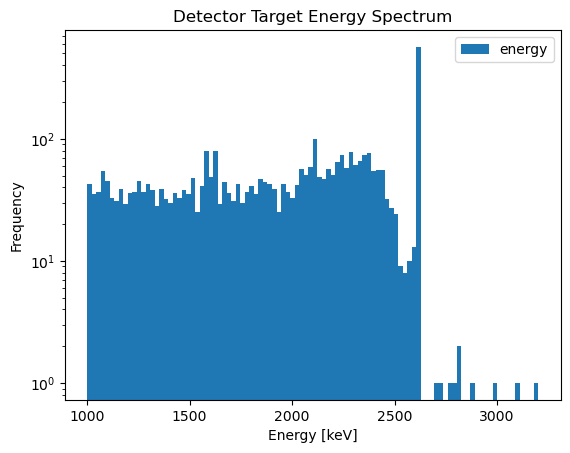

In [7]:
data_Target.plot(kind='hist', title='Detector Target Energy Spectrum', column='energy', bins=100, logy=True, xlabel="Energy [keV]")

step 2: signal peak cut

In [8]:
def calc_cut_eff(Nc, tau, N, B, Bc):
    eff = (Nc-tau*Bc)/(N-tau*B)
    return eff

In [9]:
signal_window_min= 1590
signal_window_max = 1595

sig_base_window_min = 1585
sig_base_window_max = 1590


energies_A = data_A["energy"]
sig_energy = data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max), 'energy']
base_energy = data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max), 'energy']
N_sig = len(sig_energy)
B_sig = len(base_energy)
tau_sig = 1
sig_scores = data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max), 'cnn_score']
baseline_scores = data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max), 'cnn_score'] 
cut_thresh = .15
Nc_sig= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
Bc_sig = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
cut_eff = calc_cut_eff(Nc_sig, tau_sig, N_sig, B_sig, Bc_sig)
print("True Positive Rate (Cut efficiency)= ", cut_eff)
print(N_sig, B_sig, Nc_sig, Bc_sig)




True Positive Rate (Cut efficiency)=  0.7690217391304348
454 86 329 46


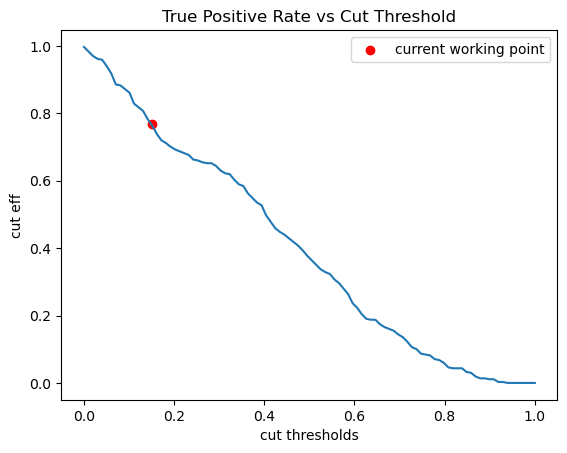

In [10]:

thresholds = np.linspace(0, 1, num=100)
effs = []
for thresh in thresholds:
    Nc= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    Bc = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    eff = calc_cut_eff(Nc, 1, N_sig, B_sig, Bc)
    effs.append(eff)
    
plt.figure()
plt.plot(thresholds, effs)
plt.scatter(.15,0.7690217391304348, label="current working point", color="red")
plt.legend()
plt.xlabel("cut thresholds")
plt.ylabel("cut eff")
plt.title("True Positive Rate vs Cut Threshold")
plt.show()

Step 3: false positive rate for background peak

In [11]:
bkg_window_min= 2098
bkg_window_max = 2108

bkg_base_window_min = 2093
bkg_base_window_max = 2113


energies_A = data_A["energy"]
bkg_energy = data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max), 'energy']
bkg_base_energy_lower = data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min), 'energy']
bkg_base_energy_upper = data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max), 'energy']

N_bkg = len(bkg_energy)
B_bkg = len(bkg_base_energy_lower) + len(bkg_base_energy_upper)
tau_bkg = 1
bkg_scores = data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max), 'cnn_score']
# bkg_baseline_scores = data_A.loc[((data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min)) or ((data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max)), 'cnn_score'] 
cut_thresh = .15
Nc_bkg= len(data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
Bc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min) & (data_A['cnn_score']>cut_thresh), 'cnn_score']) + len(data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max) & (data_A['cnn_score']>cut_thresh), 'cnn_score'])
cut_eff_bkg = calc_cut_eff(Nc_bkg, tau_bkg, N_bkg, B_bkg, Bc_bkg)
print("False Positive Rate (Cut efficiency)= ", cut_eff_bkg)
print(N_bkg, B_bkg, Nc_bkg, Bc_bkg)

False Positive Rate (Cut efficiency)=  0.10058309037900874
933 247 165 96


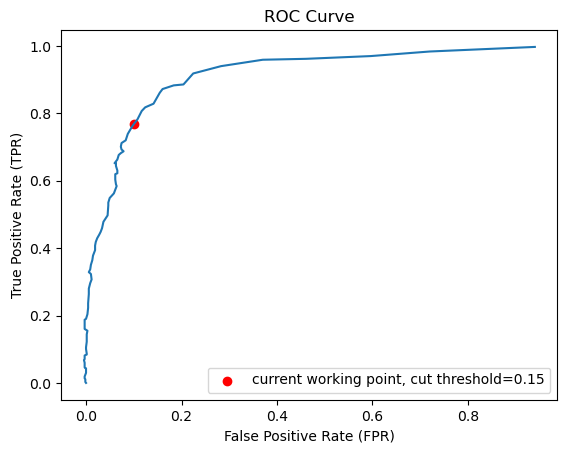

In [12]:
thresholds = np.linspace(0, 1, num=100)
tprs = []
fprs = []
for thresh in thresholds:
    Nc= len(data_A.loc[(data_A['energy'] >= signal_window_min) & (data_A['energy'] <= signal_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    Bc = len(data_A.loc[(data_A['energy'] >= sig_base_window_min) & (data_A['energy'] <= sig_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    tpr = calc_cut_eff(Nc, 1, N_sig, B_sig, Bc)
    tprs.append(tpr)

    nc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_window_min) & (data_A['energy'] <= bkg_window_max) & (data_A['cnn_score']>thresh), 'cnn_score']) 
    bc_bkg = len(data_A.loc[(data_A['energy'] >= bkg_base_window_min) & (data_A['energy'] <= bkg_window_min) & (data_A['cnn_score']>thresh), 'cnn_score']) + len(data_A.loc[(data_A['energy'] >= bkg_window_max) & (data_A['energy'] <= bkg_base_window_max) & (data_A['cnn_score']>thresh), 'cnn_score'])
    fpr = calc_cut_eff(nc_bkg, 1, N_bkg, B_bkg, bc_bkg)
    fprs.append(fpr)

    
plt.figure()
plt.plot(fprs, tprs)
plt.scatter(0.10058309037900874, 0.7690217391304348, label="current working point, cut threshold=0.15", color="red")
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.show()

step 4: PDF for NLDBD

In [13]:
E0= 2039
sigma =1
def nldbd_pdf(x):
    return stats.norm.pdf(x, loc=E0, scale=sigma)

Step 5: apply the cut

In [14]:
data_A_with_cut = data_A.loc[(data_A['cnn_score']>cut_thresh)]
data_B_with_cut = data_B.loc[(data_B['cnn_score']>cut_thresh)]
data_C_with_cut = data_C.loc[(data_C['cnn_score']>cut_thresh)]
data_Target_with_cut = data_Target.loc[(data_B['cnn_score']>cut_thresh)]


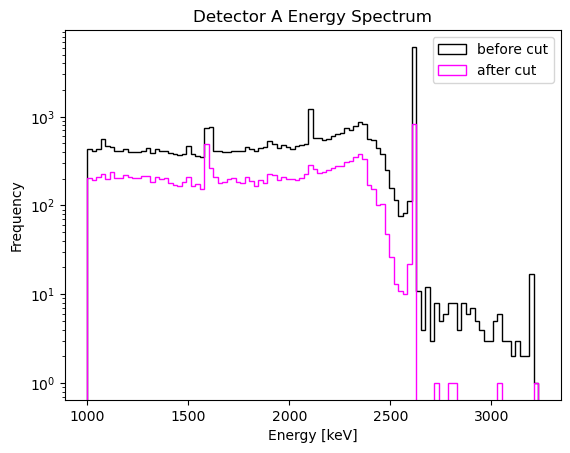

In [15]:
plt.figure()
ax = data_A['energy'].plot(
    kind='hist', 
    title='Detector A Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_A_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

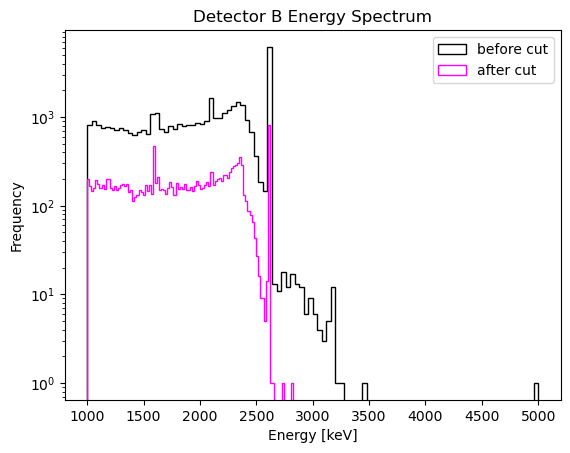

In [16]:
plt.figure()
ax = data_B['energy'].plot(
    kind='hist', 
    title='Detector B Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_B_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

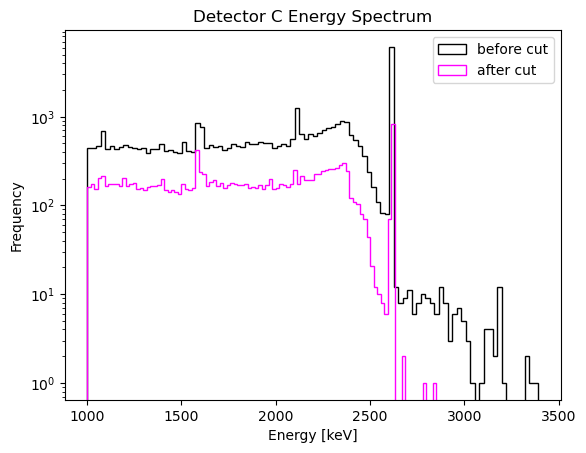

In [17]:
plt.figure()
ax = data_C['energy'].plot(
    kind='hist', 
    title='Detector C Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_C_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

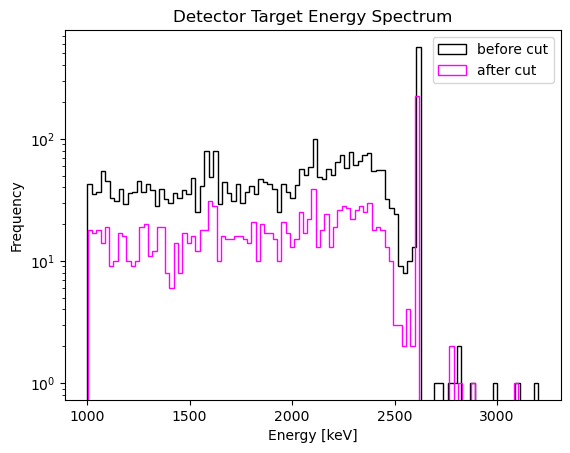

In [18]:
plt.figure()
ax = data_Target['energy'].plot(
    kind='hist', 
    title='Detector Target Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black"
)

data_Target_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta"
)

plt.legend()
plt.show()

Step 5: PDF for detectors (are they all the same?)

Step 6: Perform the fit

In [19]:
pip install iminuit

Note: you may need to restart the kernel to use updated packages.


In [20]:
from iminuit import Minuit

[1012.5 1037.5 1062.5 1087.5 1112.5 1137.5 1162.5 1187.5 1212.5 1237.5
 1262.5 1287.5 1312.5 1337.5 1362.5 1387.5 1412.5 1437.5 1462.5 1487.5
 1512.5 1537.5 1562.5 1587.5 1612.5 1637.5 1662.5 1687.5 1712.5 1737.5
 1762.5 1787.5 1812.5 1837.5 1862.5 1887.5 1912.5 1937.5 1962.5 1987.5
 2012.5 2037.5 2062.5 2087.5 2112.5 2137.5 2162.5 2187.5 2212.5 2237.5
 2262.5 2287.5 2312.5 2337.5 2362.5 2387.5 2412.5 2437.5 2462.5 2487.5
 2512.5 2537.5 2562.5 2587.5 2612.5 2637.5 2662.5 2687.5 2712.5 2737.5
 2762.5 2787.5 2812.5 2837.5 2862.5 2887.5 2912.5 2937.5 2962.5 2987.5
 3012.5 3037.5 3062.5 3087.5 3112.5 3137.5 3162.5 3187.5 3212.5 3237.5
 3262.5 3287.5 3312.5 3337.5 3362.5 3387.5 3412.5 3437.5 3462.5 3487.5]


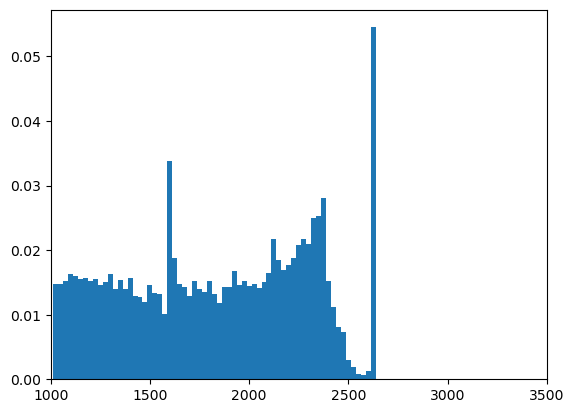

In [21]:
counts_A, bin_edges_A = np.histogram(data_A_with_cut['energy'], bins=100, range=(1000, 3500))
normalized_counts_A = counts_A/(np.sum(counts_A))

bin_width_A = (bin_edges_A[-1] - bin_edges_A[0]) / 100
bin_centers_A = 0.5 * (bin_edges_A[1:] + bin_edges_A[:-1])
print(bin_centers_A)
plt.bar(bin_edges_A[1:], normalized_counts_A, width=bin_width_A)
plt.xlim(1000, 3500)
plt.show()

[1012.5 1037.5 1062.5 1087.5 1112.5 1137.5 1162.5 1187.5 1212.5 1237.5
 1262.5 1287.5 1312.5 1337.5 1362.5 1387.5 1412.5 1437.5 1462.5 1487.5
 1512.5 1537.5 1562.5 1587.5 1612.5 1637.5 1662.5 1687.5 1712.5 1737.5
 1762.5 1787.5 1812.5 1837.5 1862.5 1887.5 1912.5 1937.5 1962.5 1987.5
 2012.5 2037.5 2062.5 2087.5 2112.5 2137.5 2162.5 2187.5 2212.5 2237.5
 2262.5 2287.5 2312.5 2337.5 2362.5 2387.5 2412.5 2437.5 2462.5 2487.5
 2512.5 2537.5 2562.5 2587.5 2612.5 2637.5 2662.5 2687.5 2712.5 2737.5
 2762.5 2787.5 2812.5 2837.5 2862.5 2887.5 2912.5 2937.5 2962.5 2987.5
 3012.5 3037.5 3062.5 3087.5 3112.5 3137.5 3162.5 3187.5 3212.5 3237.5
 3262.5 3287.5 3312.5 3337.5 3362.5 3387.5 3412.5 3437.5 3462.5 3487.5]


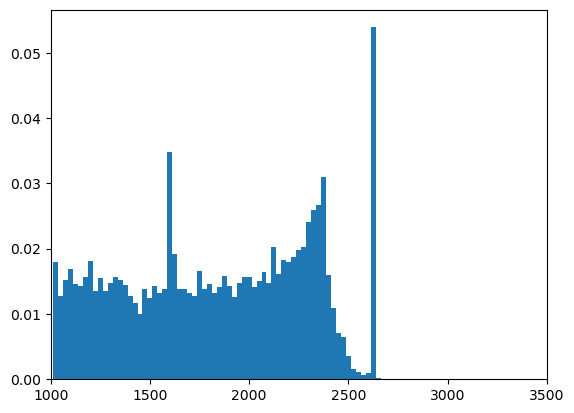

In [22]:
counts_B, bin_edges_B = np.histogram(data_B_with_cut['energy'], bins=100, range=(1000, 3500))
normalized_counts_B = counts_B/(np.sum(counts_B))
bin_width_B = (bin_edges_B[-1] - bin_edges_B[0]) / 100
bin_centers_B = 0.5 * (bin_edges_B[1:] + bin_edges_B[:-1])
plt.bar(bin_edges_B[1:], normalized_counts_B, width=bin_width_B)
print(bin_centers_B)
plt.xlim(1000, 3500)
plt.show()

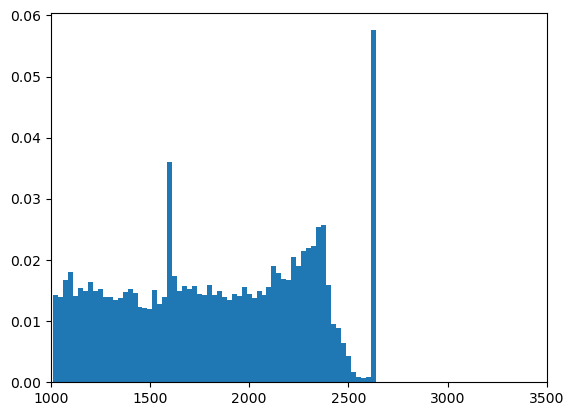

In [23]:
counts_C, bin_edges_C = np.histogram(data_C_with_cut['energy'], bins=100,range=(1000, 3500))
normalized_counts_C = counts_C/(np.sum(counts_C))
bin_width_C = (bin_edges_C[-1] - bin_edges_C[0]) / 100
bin_centers_C = 0.5 * (bin_edges_C[1:] + bin_edges_C[:-1])
plt.bar(bin_edges_C[1:], normalized_counts_C, width=bin_width_C)
plt.xlim(1000, 3500)
plt.show()

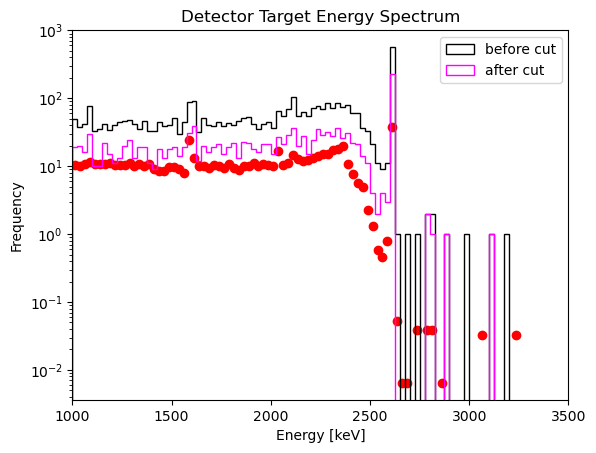

In [24]:
plt.figure()
ax = data_Target['energy'].plot(
    kind='hist', 
    title='Detector Target Energy Spectrum', 
    bins=100, 
    logy=True, 
    histtype='step',
    label='before cut',
    xlabel="Energy [keV]",
    color="black",
    range=(1000, 3500)
)

data_Target_with_cut['energy'].plot(
    kind='hist', 
    ax=ax, 
    bins=100, 
    histtype='step',
    logy=True, 
    label='after cut',
    xlabel="Energy [keV]",
    color="magenta",
    range=(1000, 3500)
)


# plt.bar(bin_centers, 1350*normalized_counts_A+770*normalized_counts_B+1000*normalized_counts_C+ 500*nldbd_pdf(bin_centers_C), width=bin_width_C)
plt.scatter(bin_centers_C,500*normalized_counts_A+100*normalized_counts_B+100*normalized_counts_C+ 50*nldbd_pdf(bin_centers_C), color='red' )
# plt.plot(bin_centers_C, new_fit(bin_centers, 100, 770, 0, 50), color='orange')
# plt.bar(bin_centers, counts, width=bin_width)
plt.xlim(1000, 3500)
plt.legend()
plt.show()

In [25]:
# def new_fit(bin_centers, thetaA, thetaB, thetaC, thetaNLDBD):
#     # thetaA = 1350
#     # thetaB = 770
#     return thetaA*normalized_counts_A + thetaB*normalized_counts_B + thetaC*normalized_counts_C + thetaNLDBD*nldbd_pdf(bin_centers)

In [39]:
#defining pdf as normalized sum of normalized pdf components (A, B, C)
def new_fit(bin_centers, thetaA, thetaB, thetaC, thetaNLDBD):
    # Compute the weighted sum of normalized components
    combined_pdf = (
        thetaA * normalized_counts_A +
        thetaB * normalized_counts_B +
        thetaC * normalized_counts_C +
        thetaNLDBD * nldbd_pdf(bin_centers)
    )

    #interpolate to create a callable function
    combined_pdf_func = interp1d(bin_centers, combined_pdf, kind='linear', fill_value="extrapolate")

    #compute the normalization factor using quad to integrate
    norm_factor, _ = quad(combined_pdf_func, min(bin_centers), max(bin_centers))

    #normalize the final sum
    normalized_combined_pdf = combined_pdf / norm_factor

    return normalized_combined_pdf


In [52]:
counts, bin_edges = np.histogram(data_Target_with_cut['energy'], bins=100, range=(1000,3500)) 
bin_width = (bin_edges[-1] - bin_edges[0]) / 100
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

#calculate normalized counts of detector target to fit to normalized pdf 
normalized_counts = counts/(np.sum(counts))


def chi2(thetaC, thetaA, thetaB, thetaNLDBD):
    expected = new_fit(bin_centers, thetaA, thetaB, thetaC, thetaNLDBD)
    uncert = np.abs(expected)
    actual = normalized_counts
    chi2_value = 0
    #calculate chi squared for theta C
    for j, ex in enumerate(expected):
        if ex !=0:
            chi2_value += ((actual[j]-ex)**2)/ex
        # else:
        #     chi2_value += actual[j]**2
    # chi2_value = np.sum(((actual - expected) ** 2) / (expected+  epsilon))
    return chi2_value + ((thetaA-1350)**2)/(100**2) + ((thetaB-770)**2)/(270**2)

minuit = Minuit(chi2, thetaA=100, thetaB=100, thetaC=100, thetaNLDBD=100)
minuit.limits = [(0, None)]*4
minuit.migrad()
best_fit_thetaA = minuit.values["thetaA"]
best_fit_thetaB = minuit.values["thetaB"]
best_fit_thetaC = minuit.values["thetaC"]
best_fit_thetaNLDBD = minuit.values["thetaNLDBD"]
print(f"Best-fit thetaC: {best_fit_thetaC:.2f}")
print(f"Best-fit thetaNLDBD: {best_fit_thetaNLDBD:.2f}")
print(f"Best-fit thetaA: {best_fit_thetaA:.2f}")
print(f"Best-fit thetaB: {best_fit_thetaB:.2f}")
chi2_min = minuit.fval

print (f"Best-fit chi-square: {chi2_min:.2f}")
print (f"Best-fit reduced chi-square: {chi2_min/4:.2f}") #four free params = four DOF

/var/folders/g9/70rty0x929vfgjpdhdclnn7m0000gq/T/ipykernel_8537/365167151.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_factor, _ = quad(combined_pdf_func, min(bin_centers), max(bin_centers))


Best-fit thetaC: 2461.66
Best-fit thetaNLDBD: 45.24
Best-fit thetaA: 1350.55
Best-fit thetaB: 763.99
Best-fit chi-square: 30.18
Best-fit reduced chi-square: 7.54


/var/folders/g9/70rty0x929vfgjpdhdclnn7m0000gq/T/ipykernel_8537/365167151.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  norm_factor, _ = quad(combined_pdf_func, min(bin_centers), max(bin_centers))


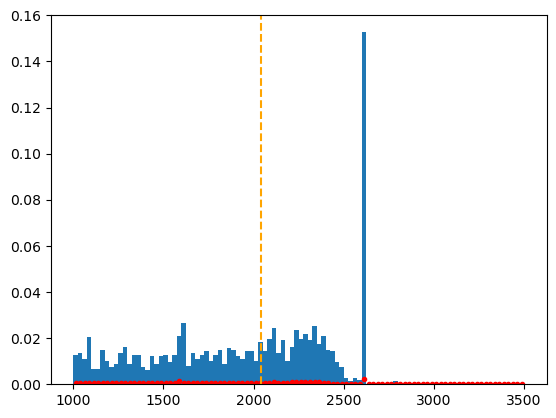

In [51]:

plt.axvline(x=2039, color="orange", linestyle="dashed")
# plt.plot(bin_centers, fit_function(bin_centers, best_fit_thetaC, best_fit_thetaNLDBD, best_fit_A1, best_fit_A2, best_fit_A3, best_fit_B1, best_fit_B2, best_fit_B3, best_fit_C1, best_fit_C2, best_fit_C3, best_fit_D1, best_fit_D2, best_fit_D3, best_fit_F1, best_fit_F2, best_fit_F3, best_fit_ss[0], best_fit_ss[1], best_fit_ss[2], best_fit_sb[0], best_fit_sb[1], best_fit_sb[2]), color='red')
# plt.plot(bin_centers, new_fit(bin_centers, 1350, 770, 1000, 50), color='red')
plt.bar(bin_centers, normalized_counts, width=bin_width)
plt.scatter(bin_centers, new_fit(bin_centers, best_fit_thetaA, best_fit_thetaB, best_fit_thetaC, best_fit_thetaNLDBD), color='red',marker='.')


# plt.yscale('log')
#plt.ylim(1, 200)
plt.show()

In [46]:
m=best_fit_thetaNLDBD/cut_eff #number of NLDBD
print(m)

65.36673984318284


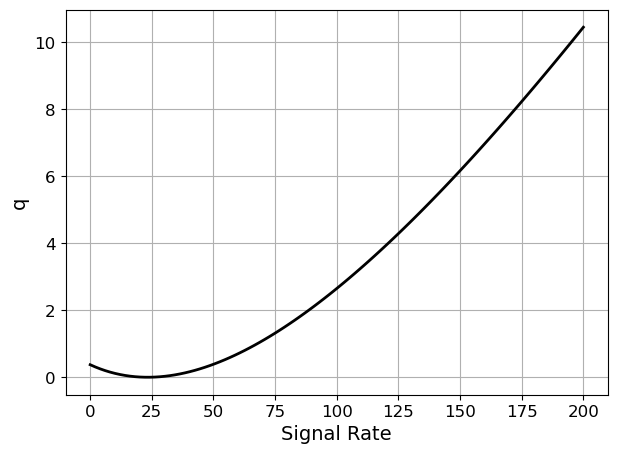

In [282]:
thetaNLDBD_scan = np.linspace(0, 200, 100)  # Test range of signal strengths
q_values = []

for theta in thetaNLDBD_scan:
    m_fixed = Minuit(lambda thetaA, thetaB, thetaC : chi2(thetaA, thetaB, thetaC, theta),thetaA=1, thetaB=1, thetaC=1)
    m_fixed.limits = [(0, None)] * 3
    m_fixed.migrad()
    if not m_fixed.valid:
        print(f"Warning: Fit failed for theta = {theta}")
    chi2_fixed = m_fixed.fval
    # print(chi2_fixed)
    
    # Calculate q for this signal rate
    q = chi2_fixed-chi2_min
    # print(chi2_fixed, chi2_min, theta)
    q_values.append(q)

# Plot q vs. signal rate
plt.figure(figsize=(7, 5))
plt.plot(thetaNLDBD_scan, q_values, color='black', linewidth=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.grid()
plt.show()

In [283]:
closest_diff = float('inf')
closest_rate = float('inf')
for i in range(len(thetaNLDBD_scan)):
    if abs(q_values[i]-2.71) < closest_diff and thetaNLDBD_scan[i]>best_fit_thetaNLDBD: # Note that the upperlimit has to be greater than S_best-fit
        closest_diff = abs(q_values[i]-2.71)
        closest_rate = thetaNLDBD_scan[i]

In [284]:
print (f"Upper-limit on Signal Rate: {closest_rate:.2f}")

Upper-limit on Signal Rate: 101.01


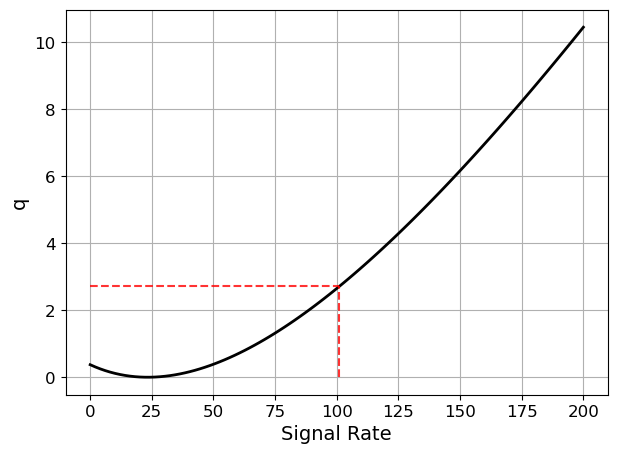

In [285]:
plt.figure(figsize=(7, 5))
plt.plot(thetaNLDBD_scan, q_values, color='black', linewidth=2)
plt.hlines(2.71, 0, closest_rate, linestyle='--', color='red', alpha=0.8)
plt.vlines(closest_rate, 0, 2.71, linestyle='--', color='red', alpha=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Signal Rate", fontsize=14)
plt.ylabel("q", fontsize=14)
plt.grid()
plt.show()